In [100]:
from IPython.display import clear_output
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import dropbox
import sys
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl

from subprocess import call
from tifffile import imwrite
from tqdm import tqdm
from pathlib import Path
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
from IPython.display import clear_output

%matplotlib widget
%load_ext autoreload
%autoreload 2
logging.basicConfig(stream=sys.stdout, level=logging.debug)
mpl.rcParams["figure.dpi"] = 200
plt.style.use('presentation.mplstyle')
import logging

# Set logging level to WARNING to suppress INFO messages
logging.getLogger('fontTools.subset').setLevel(logging.WARNING)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# videos_folder = "F:\\AMOLF_Data\\videos\\"
# analysis_folder = "F:\\AMOLF_Data\\analysis\\"

# videos_folder = "/gpfs/scratch1/shared/amftrackflow/videos/"
# analysis_folder = "/gpfs/home6/svstaalduine/Analysis/"
videos_folder = r"C:\Users\coren\Documents\PhD\paper\transport"

analysis_folder = r"C:\Users\coren\Documents\PhD\paper\transport\analysis"
dropbox_address = "/DATA/CocoTransport/20230811_Plate441/"


In [4]:
#%%
video_param_frame = index_videos_dropbox_new(
    analysis_folder,
    videos_folder,
    dropbox_address,
    REDO_SCROUNGING=True,
    # date_start=20230801,
    # date_end=20230813,
    plate_names=None,
)
clear_output(wait=False)

In [45]:
list_video = [11,12,34,35,36,37,75,76,79,80]
download_frame = video_param_frame.copy()
download_frame = download_frame[download_frame['video_int'].isin(list_video)]


In [6]:
download_video_folders_drop(download_frame, videos_folder)
clear_output(wait=False)
print("All videos downloaded!")

oh no, this path is not correct!
/DATA/CocoTransport/20230811_Plate441/011/Img
2024-04-27 16:34:14,161-[INFO]- dropbox:387 -> Refreshing access token.
2024-04-27 16:34:14,431-[INFO]- dropbox:471 -> Request to files/list_folder
2024-04-27 16:34:14,992-[INFO]- dropbox:471 -> Request to files/list_folder/continue
2024-04-27 16:34:15,809-[INFO]- dropbox:471 -> Request to files/list_folder/continue
/DATA/CocoTransport/20230811_Plate441/011/Img/Img_00001.tif C:\Users\coren\Documents\PhD\paper\transport\CocoTransport\20230811_Plate441\011\Img\Img_00001.tif
2024-04-27 16:34:16,344-[INFO]- dropbox:387 -> Refreshing access token.
2024-04-27 16:34:16,605-[INFO]- dropbox:471 -> Request to files/download
/DATA/CocoTransport/20230811_Plate441/011/Img/Img_00084.tif C:\Users\coren\Documents\PhD\paper\transport\CocoTransport\20230811_Plate441\011\Img\Img_00084.tif
2024-04-27 16:34:20,588-[INFO]- dropbox:387 -> Refreshing access token.
2024-04-27 16:34:20,869-[INFO]- dropbox:471 -> Request to files/down

KeyboardInterrupt: 

In [43]:
folder_filter = dropbox_address[5:]

img_infos = glob.glob(
    f"{analysis_folder}{folder_filter}/**/video_data.json", recursive=True
)
vid_anls_frame = pd.DataFrame()
for address in img_infos:
    add_info = pd.read_json(address, orient="index").T
    vid_anls_frame = pd.concat([vid_anls_frame, add_info], ignore_index=True)

vid_anls_frame = vid_anls_frame.sort_values("unique_id").reset_index(drop=True)
analysis_frame = vid_anls_frame[vid_anls_frame['video_int'].isin(list_video)]

####################################################################################
### Below code will prepare for those videos to be downloaded to videos_folder.  ###
####################################################################################

print(f"Number of videos to be analyzed: {len(analysis_frame)}")

Number of videos to be analyzed: 10


In [44]:
analysis_frame.iloc[3]

imaging_day                                                     20230811
storage_path                                  Dropbox\DATA\CocoTransport
plate_id                                               20230811_Plate441
root                                                              Carrot
strain                                                                C2
treatment                                                   001P100N100C
crossing_day                                                    20230807
video_int                                                             35
time_(s)                                                            10.0
mode                                                                   F
exposure_time_(us)                                              700000.0
fps                                                                  1.0
binning                                                                2
gain                                               

In [ ]:
list_video = [11,12,34,35,36,37,75,76,79,80]


In [155]:
i = 7
dataframe = analysis_frame
selection_frame = dataframe[dataframe["ypos"] == dataframe["ypos"].iloc[i]]
selection_frame = selection_frame[selection_frame["xpos"] == dataframe["xpos"].iloc[i]]
selection_frame = selection_frame[selection_frame["mode"] == "BF"]
selection_frame = selection_frame[
    selection_frame["binning"] == dataframe["binning"].iloc[i]
]
test_video = KymoVideoAnalysis(
    input_frame=analysis_frame.iloc[i], logging=True, samepos_frame=selection_frame
)

Data input succesful! Starting edge extraction...
Successfully extracted the skeleton. Did you know there is a skeleton inside inside you right now?


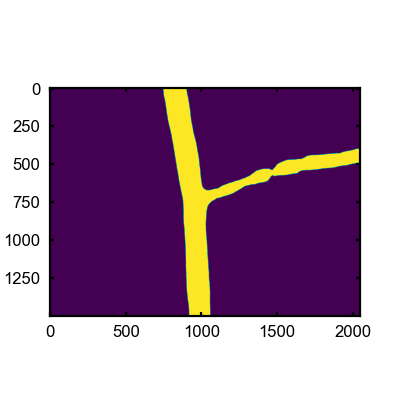

In [156]:
plt.close("all")
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(test_video.segmented)

In [162]:
target_length = int(2.4 * test_video.magnification)

edge_objs = test_video.edge_objects
kymo = edge_objs[2].extract_multi_kymo(
        1, target_length=target_length, kymo_adj=False, kymo_normalize=False
    )
kymo = kymo[0]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


In [37]:
# num = 5
# path = r"C:\Users\coren\Documents\PhD\paper\transport\kymograph\kymograph_6\kymograph6.tif"
# kymo = imageio.imread(path)

In [163]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_videos_fun import *
def filter_kymo_right(kymo):
    return(np.flip(filter_kymo_left(np.flip(kymo, axis=1)), axis=1))

In [164]:
filtered_kymo_left.shape

(20, 374)

In [165]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\transport\Fig1"

2024-04-27 21:13:48,934-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


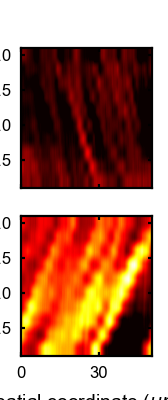

In [166]:
filtered_kymo_left = filter_kymo_left(kymo)
filtered_kymo_right = filter_kymo_right(kymo)
num_cols_left = filtered_kymo_left.shape[1]  # assuming image data in numpy array format
num_cols_right = filtered_kymo_right.shape[1]

pixel_size = edge_objs[0].space_pixel_size
max_kymo = max(np.max(filtered_kymo_right),np.max(filtered_kymo_left))
sizey = 2
sizex = num_cols_left*pixel_size/60
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(sizex, sizey), sharex=True)

# Plotting the left filtered kymograph
ax1.imshow(filtered_kymo_left[:10,:], aspect='auto', cmap="hot", vmin=0, vmax=max_kymo)

# Plotting the right filtered kymograph
ax2.imshow(filtered_kymo_right[:10,:], aspect='auto', cmap="hot", vmin=0, vmax=max_kymo)


# Creating tick positions and labels for the x-axis based on actual size
ticks = np.arange(0, max(num_cols_left, num_cols_right), int(1/pixel_size*30))  # change 25 to whatever number of pixels you want between ticks
tick_labels = [f"{pixel * pixel_size:.0f}" for pixel in ticks]  # formatting labels to 2 decimal places

ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_labels)
ax2.set_xticks(ticks)
d= ax2.set_xticklabels(tick_labels)
ax2.set_xlabel('spatial coordinate ($\mu m$)')
ax1.set_ylabel('time (s)')
ax2.set_ylabel('time (s)')
plt.savefig(os.path.join(path_figure,f'Kymos_pos{list_video[i]}_2.pdf'), transparent=True, bbox_inches='tight')

In [62]:
mean_fourrier_left = np.mean(filtered_kymo_left)
mean_fourrier_right = np.mean(filtered_kymo_right)
(mean_fourrier_left-mean_fourrier_right)/(mean_fourrier_left+mean_fourrier_right)

0.21127457886694775